# Faostat global model
In this notebook we create an ensemble of multilayer perceptron ([MLP](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)) models to fit the world crop yields using the input variables: precipitation, air temperature, natural and synthetic fertilizers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print("Matplotlib version: %s"%mpl.__version__)

NumPy version: 1.25.2
Pandas version: 2.1.1
Matplotlib version: 3.8.0


## The dataset
We load the dataset that was prepared by putting into the same file the predictors and the predictands data

In [2]:
global_crop_yield_path = 'data/global_dataset.csv'
global_crop_yield_df = pd.read_csv(global_crop_yield_path, index_col=0)
global_crop_yield_df.head(2)

,Maize (100g/ha),Millet (100g/ha),Temp. Anom. (°C),Prec.Anom. (mm),CO2 (ppm),Manure (Mt),Nitrogen (tons),Phosphate (tons),Potash (tons)
1961-12-31,19423,5925,0.211,15.318908,317.64,1.835092e+10,11486265.27,10888968.81,8626724.57
1962-12-31,19796,5619,0.038,0.768900,318.45,1.872918e+10,12969831.11,11534554.43,9146891.38


## Data preparation
Since the values for the variables differ by orders of magnitude, we normalize them before using the data as input for the model. We use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) from the scikit-learn package to normalize the values. The scaler removes the mean and scale the values to unit variance. We start by selecting the columns with the input data

In [3]:
X = global_crop_yield_df.iloc[:, [2, 3, 5, 6]].to_numpy()
y = global_crop_yield_df.iloc[:, [0]].to_numpy()

and the column of the predictand (maize)

In [4]:
y[:1]

array([[19423]], dtype=int64)

In [5]:
from sklearn import preprocessing
scaler_x = preprocessing.StandardScaler().fit(X)

The scaler computes the mean of the input variables

In [6]:
mean_x = scaler_x.mean_[0]
mean_x

0.5707741935483871

and the variance

In [7]:
variance_x = scaler_x.scale_[0]
variance_x

0.5387043721971724

we use the scaler to normalize the input variables

In [8]:
X_scaled = scaler_x.transform(X)
X_scaled.shape

(62, 4)

In [9]:
scaler_y = preprocessing.StandardScaler().fit(y)
y_scaled = scaler_y.transform(y)
y_scaled.shape

(62, 1)

In [10]:
mean_y = scaler_y.mean_[0]
mean_y

38951.403225806454

In [11]:
variance_y = scaler_y.scale_[0]
variance_y

11966.558404448891

## Train and test set
The data used to train a model of the ensemble is divided into a train set and a test set

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((43, 4), (43, 1), (19, 4), (19, 1))

## Ensemble models training

In [33]:
num_observations = X.shape[0]
num_observations

62

We train an ensemble of MLP models that start with a different init parameters

In [34]:
import random 
num_ensemble_members = 20 
from random import randint
random_states = [randint(2, num_observations) for p in range(1, num_ensemble_members + 1)]
len(random_states)

20

A random state is the seed used during the training of a model of the ensemble

In [35]:
random_states[:]

[58, 59, 18, 18, 5, 30, 12, 15, 55, 48, 10, 7, 51, 42, 12, 2, 60, 29, 49, 20]

We initialize a 2D array that will contain the predictions of the ensemble models

In [36]:
ensemble_members = np.zeros((num_observations,num_ensemble_members))
ensemble_members.shape

(62, 20)

In [80]:
from time import time
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

for i in range(0, num_ensemble_members):
    random_state = random_states[i]
    tic = time()
    mlp_model = MLPRegressor(
               hidden_layer_sizes=(4, 1),
               activation='tanh',
               #learning_rate_init=0.01, not used with lbfgs solver
               early_stopping=True,
               random_state=random_state,
               solver='lbfgs',
               max_iter=20
            )
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=random_state)
    mlp_model.fit(X_train, y_train)
    model_sample = mlp_model.predict(X_scaled)
    ensemble_members[:, i] = model_sample
    print('Run {0:d}'.format(i))
    print(f"done in {time() - tic:.3f}s")
    print(f"Train R2 score: {mlp_model.score(X_train, y_train):.2f}")
    print(f"Test R2 score: {mlp_model.score(X_test, y_test):.2f}\n")
    mlp_model=None

Run 0
done in 0.024s
Train R2 score: 0.97
Test R2 score: 0.96

Run 1
done in 0.017s
Train R2 score: 0.96
Test R2 score: 0.98

Run 2
done in 0.018s
Train R2 score: 0.98
Test R2 score: 0.95

Run 3
done in 0.034s
Train R2 score: 0.98
Test R2 score: 0.95

Run 4
done in 0.037s
Train R2 score: 0.97
Test R2 score: 0.93

Run 5
done in 0.025s
Train R2 score: 0.92
Test R2 score: 0.86

Run 6
done in 0.013s
Train R2 score: 0.96
Test R2 score: 0.97

Run 7
done in 0.011s
Train R2 score: 0.97
Test R2 score: 0.94

Run 8
done in 0.017s
Train R2 score: 0.97
Test R2 score: 0.94

Run 9
done in 0.011s
Train R2 score: 0.96
Test R2 score: 0.98

Run 10
done in 0.013s
Train R2 score: 0.97
Test R2 score: 0.95

Run 11
done in 0.013s
Train R2 score: 0.98
Test R2 score: 0.78

Run 12
done in 0.015s
Train R2 score: 0.97
Test R2 score: 0.97

Run 13
done in 0.015s
Train R2 score: 0.96
Test R2 score: 0.99

Run 14
done in 0.013s
Train R2 score: 0.96
Test R2 score: 0.97

Run 15
done in 0.016s
Train R2 score: 0.97
Test R2

In [81]:
ensemble_members.shape

(62, 20)

## Inverse transform
We denormalize the predictions by inverting the predicted values. We can perform the inverse transform using a simple equation

In [82]:
ensemble_denorm = ensemble_members * variance_y + mean_y
ensemble_denorm[:,0]

array([19983.46742909, 20173.72415711, 20462.43701866, 21252.38295166,
       24322.40607146, 20995.86135755, 22604.39801898, 22725.66830129,
       23118.10879168, 22756.38733185, 24351.18723066, 27642.88454212,
       25741.30795744, 27564.3376015 , 27501.98339255, 29601.90332128,
       28133.99699289, 30936.86803314, 31158.91095581, 32070.67669704,
       32426.07871228, 33632.99075503, 34165.79884484, 36625.23884417,
       36905.25747561, 36939.45653941, 36463.12350137, 39040.03368359,
       39040.93679812, 39428.34896381, 37856.42578609, 35300.77833624,
       35988.51676637, 36497.02859122, 40687.01767907, 39539.32577211,
       40310.64447133, 46409.53099035, 44781.54510691, 41775.24057468,
       43004.72411759, 45356.39238043, 45537.5417232 , 47570.5349861 ,
       48800.57872726, 49573.44772611, 52409.08607764, 48553.29381769,
       50309.77942341, 52314.84805659, 52164.83458798, 54008.57641133,
       53565.96115319, 54620.04567064, 56001.97897913, 56453.50779737,
      

or we can use the function provided by the scaler

In [83]:
prediction = scaler_y.inverse_transform(ensemble_members)
prediction[:, 0]

array([19983.46742909, 20173.72415711, 20462.43701866, 21252.38295166,
       24322.40607146, 20995.86135755, 22604.39801898, 22725.66830129,
       23118.10879168, 22756.38733185, 24351.18723066, 27642.88454212,
       25741.30795744, 27564.3376015 , 27501.98339255, 29601.90332128,
       28133.99699289, 30936.86803314, 31158.91095581, 32070.67669704,
       32426.07871228, 33632.99075503, 34165.79884484, 36625.23884417,
       36905.25747561, 36939.45653941, 36463.12350137, 39040.03368359,
       39040.93679812, 39428.34896381, 37856.42578609, 35300.77833624,
       35988.51676637, 36497.02859122, 40687.01767907, 39539.32577211,
       40310.64447133, 46409.53099035, 44781.54510691, 41775.24057468,
       43004.72411759, 45356.39238043, 45537.5417232 , 47570.5349861 ,
       48800.57872726, 49573.44772611, 52409.08607764, 48553.29381769,
       50309.77942341, 52314.84805659, 52164.83458798, 54008.57641133,
       53565.96115319, 54620.04567064, 56001.97897913, 56453.50779737,
      

In [84]:
diff = prediction[:, 0] - ensemble_denorm[:,0] == 0
diff.all()

True

We compute the ensemble values

In [85]:
ensemble = prediction.sum(axis=1) / num_ensemble_members
ensemble

array([20828.74023246, 21146.11143583, 21236.83253463, 21894.69900595,
       22416.68304988, 22161.56666891, 23175.5550086 , 23647.02332271,
       23785.5001871 , 23718.38980338, 25302.19585356, 26269.14609596,
       26103.31116433, 27365.077834  , 27765.04613676, 29940.51479415,
       28715.2573714 , 30819.6285565 , 31413.37596514, 32333.27422659,
       31968.96609101, 33331.12262885, 34157.23611203, 35393.13348636,
       35985.79390006, 36264.45988301, 36984.51425706, 37984.35988243,
       37273.72728091, 37543.14396748, 37250.66694078, 36902.81028895,
       36282.13391238, 36535.75936542, 40211.78270074, 40130.27433542,
       41811.20315272, 45261.00749442, 44578.28330679, 41492.29761645,
       43310.87524601, 45097.14046777, 46164.82809318, 47639.37182027,
       48635.77484632, 49340.26990954, 52215.99378941, 48448.29206419,
       50473.22608645, 52697.93071818, 52534.53392241, 54201.5625795 ,
       53882.05105892, 54919.98787571, 55899.20838032, 56791.39199229,
      

## Best model visualization
We use the ensemble 16 with the best test R2 score

In [86]:
best_model_predictions = prediction[:, 1]

In [87]:
#model_sample_best = predictions_denorm.iloc[:, 16]
#model_sample_best[:2]

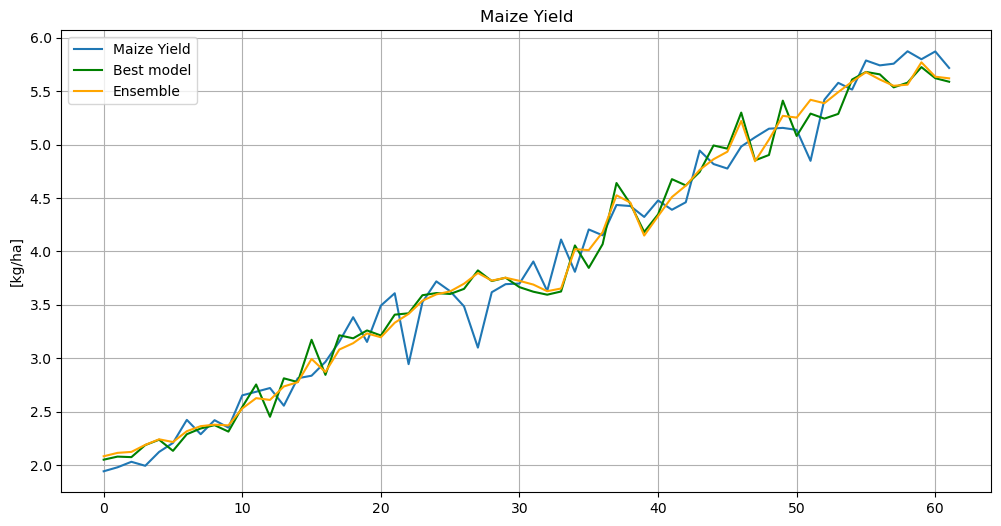

In [88]:
from matplotlib import dates
import matplotlib.dates as mdates

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.set_title('Maize Yield')
ax.set_ylabel('[kg/ha]');
ax.grid(True, which='both')
#ax.set_xticks(predictions_denorm.index)
#ax.set_xticklabels(predictions_denorm.index, rotation=70)
#ax.xaxis.set_major_locator(dates.YearLocator(5))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#maize_yield = global_crop_yield_df['Maize (100g/ha)'] / 10000 
pd_maize_yield, = plt.plot(y / 10000, label='Maize Yield')
pd_predictions_best, = plt.plot(best_model_predictions / 10000, label='Best model', color='green')
pd_ensemble, = plt.plot(ensemble / 10000, label='Ensemble', color='orange')
plt.legend(handles=[pd_maize_yield, pd_predictions_best, pd_ensemble], loc='upper left')